In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.contrib.image
import matplotlib.pyplot as plt
import datetime
from pathlib import Path 
from tqdm import tqdm as tqdm
import numpy as np
%matplotlib inline

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [0]:
labels =  y_test[:10]
images = x_test[:10]

In [5]:
images[0].shape 

(32, 32, 3)

In [0]:
height, width , channel = images[0].shape 

In [0]:
real_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog","horse", "ship", "truck"]

In [8]:
n_classes = len(real_labels)
n_classes 

10

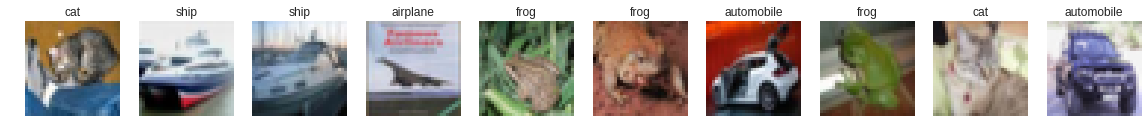

In [9]:
fig, axs = plt.subplots(1, len(images), figsize=(20, 3))
for i, (img, l) in enumerate(zip(images,labels)):
        axs[i].imshow(img)
        axs[i].axis('off')
        label = real_labels[l[0]]
        axs[i].set_title( label)
plt.show()

In [0]:
class ImageManager:
    def __init__(self, x_train, y_train, x_test, y_test):
        self.test_offset = 0
        self.train_offset = 0
        self.train_images = x_train
        self.train_labels = y_train
        self.test_images = x_test
        self.test_labels = y_test
        self.n_test = len( y_test)
        self.n_train = len(y_train)
        

    def next_batch(self, kind, num, one_hot=True, is_binary=True):
        if kind == "test":
            end = self.test_offset + num
            if end > self.n_test:
                self.test_offset = 0
                end = num
            images = self.test_images
            labels = self.test_labels
            offset = self.test_offset
            image_batch = images[offset: end] 
            label_batch =  np.array([np.identity(n_classes)[l] for l in labels[offset: end]]).reshape(-1,10)
            
        elif kind == "train":
            end = self.train_offset + num
            if end > self.n_train:
                self.train_offset = 0
                end = num
            images = self.train_images
            labels = self.train_labels
            offset = self.train_offset
            
            image_batch = images[offset: end] 
            label_batch = np.array([np.identity(n_classes)[l] for l in labels[offset: end]]).reshape(-1,10)


        else:
            raise Exception("kind is 'test' or 'train'")

        if kind == "test":
            self.test_offset = end
        elif kind == "train":
            self.train_offset = end
        return label_batch, image_batch

In [0]:
ima =  ImageManager(x_train, y_train, x_test, y_test)

In [0]:
labels, images = ima.next_batch("test", 10)

In [13]:
labels.shape

(10, 10)

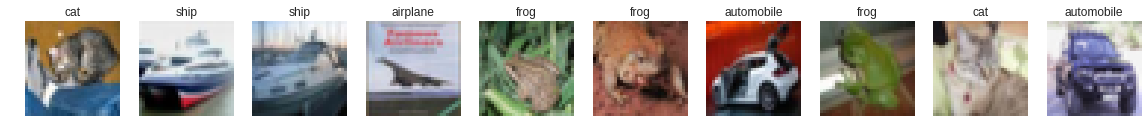

In [14]:
fig, axs = plt.subplots(1, len(images), figsize=(20, 3))
for i, (img, l) in enumerate(zip(images,labels)):
        axs[i].imshow(img)
        axs[i].axis('off')
        label = real_labels[np.argmax(l)]
        axs[i].set_title( label)
plt.show()

In [15]:
augmentation_module = hub.Module('https://tfhub.dev/google/image_augmentation/crop_rotate_color/1')
features = augmentation_module({
    'encoded_images': [tf.image.encode_png(i) for i in images],
    'image_size': [height, width], 
    'augmentation': True,})

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


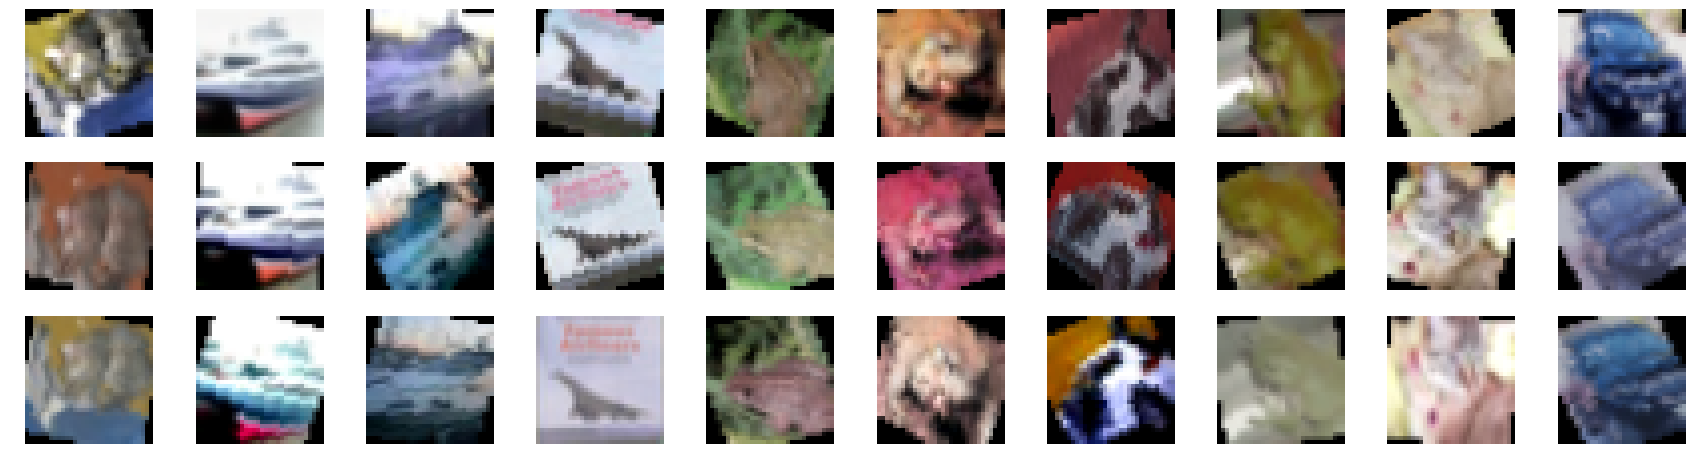

In [16]:
n_iter = 3
fig, axs = plt.subplots(n_iter, len(images), figsize=(30, 8))
for n in range(n_iter):
    with tf.Session() as sess:
        images = sess.run(features)
    for i, image in enumerate(images):
        axs[n,i].imshow(image)
        axs[n,i].axis('off')
plt.show()

In [0]:
def weight_variable(shape):
    w = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(w)


def bias_variable(shape):
    b = tf.constant(0.1, shape=shape)
    return tf.Variable(b)


def conv2d(x, filt, name):
    """
        x is a batch of images. x.shape is [batch_size, in_height, in_width, in_channels]
        filt is a filter. filt.shape is [filter_height, filter_width, in_channels, out_channels]
    """ 
    return tf.nn.conv2d(x, filt, strides=[1,1,1,1], padding='SAME', name=name)


def max_pool(x, name, size=2):
    """
        x is a batch of images. x.shape is [batch_size, in_height, in_width, in_channels]
        size is a pooling size using ksize.
        (ksize is a kernel size. ksize.shape is [batch_size, height, width, channels]
            The batch_size and channels are usual 1 on pooling. If you want 2x2 pooling, ksize=[1, 2, 2, 1])
    
    """
    return tf.nn.max_pool(x, ksize=[1, size, size, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)


def max_pool(x, name, size=2):
    """
        x is a batch of images. x.shape is [batch_size, in_height, in_width, in_channels]
        size is a pooling size using ksize.
        (ksize is a kernel size. ksize.shape is [batch_size, height, width, channels]
            The batch_size and channels are usual 1 on pooling. If you want 2x2 pooling, ksize=[1, 2, 2, 1])
    
    """
    return tf.nn.avg_pool(x, ksize=[1, size, size, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)


def conv_layer(x, out_size, name, filter_size=5, act="relu"):
    shape =x.get_shape().as_list()
    in_channel = shape[-1]
    with tf.name_scope("conv_{}".format(name)):
        with tf.name_scope('weights'):
            W = weight_variable([filter_size, filter_size, in_channel, out_size])
            variable_summaries(W)        
        with tf.name_scope('biases'):
            b = bias_variable([out_size])
            variable_summaries(b)
        h_conv = conv2d(x, W, "conv2d_{}".format(name))
        h = tf.nn.bias_add(h_conv, b)
        variable_summaries(h)
        
    if act == "relu":
        with tf.name_scope("conv_relu_{}".format(name)):
            h_act = tf.nn.relu(h)
    if act == "ident":
        h_act = h
    return h_act


def fc_layer(x_flatten, out_size, name, act="relu"):
    shape =x_flatten.get_shape().as_list()
    dim = shape[1]
    with tf.name_scope("fc_{}".format(name)):
        with tf.name_scope('weights'):
            W = weight_variable([dim, out_size])
        with tf.name_scope('biases'):   
            b  = bias_variable([out_size])
        h = tf.nn.bias_add(tf.matmul(x_flatten, W), b)
      
    if act == "relu":
        with tf.name_scope("fc_relu_{}".format(name)):
            h_act = tf.nn.relu(h)
    if act == "ident":
        h_act = h
    return h_act


def dropout(x, keep_prob, name):
    with tf.name_scope("dropout_{}".format(name)):
        h = tf.nn.dropout(x, keep_prob)
    return h
    

def flatten(x, name):
    shape = x.get_shape().as_list()
    dim = 1
    for s in shape[1:]:
        dim *= s
    with tf.name_scope(name):
        h = tf.reshape(x, [-1, dim])
    return h


def get_channel(x):
    shape = x.get_shape().as_list()
    return shape[-1]

def block(x, out_size, name):
    h_conv_act = conv_layer(x, out_size, name)
    
    with tf.name_scope("pool_{}".format(name)):   
        h_pool1 = max_pool(h_conv_act, name)
        variable_summaries(h_pool1)
    return h_pool1

def vgg_block(x, out_sizes, name):
    """
     x is a batch of images.
     out_sizes is a list of cnn layer sizes.
     name is this function's name. 
    """
    for idx, size in enumerate(out_sizes):
        if idx == 0:
            _x = x
        else:
            _x = h
        h = conv_layer(_x, size, "{}_{}".format(name, idx), filter_size=3)
        
    
    with tf.name_scope("pool_{}".format(name)):   
        h_pool1 = max_pool(h, name)
        variable_summaries(h_pool1)
    return h_pool1


def variable_summaries(var):  
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [0]:
g1 = None

# VGG16

with tf.Graph().as_default() as g1:
    keep_prob = tf.placeholder(tf.float32)
    global_step =  tf.placeholder(tf.int32)
    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, shape=[None, None, None, channel], name='x-input')
        y_ = tf.placeholder(tf.float32, shape=[None, n_classes], name='y-input')
    x_img_resize = tf.map_fn(lambda img: tf.image.resize_images(img, [int(height), int(width)]), x)
    x_std = tf.map_fn(lambda img: tf.image.per_image_standardization(img), x_img_resize)

    h_pool1 = vgg_block(x_std, [32, 32], "1") # original size: 64
    h_pool2 = vgg_block(h_pool1, [32, 32], "2") # original size: 128
    #h_pool3 = vgg_block(h_pool2, [64, 64, 64], "3") # original size: 256
    #h_pool4 = vgg_block(h_pool3, [64, 64, 64], "4") # original size: 512
    #h_pool5 = vgg_block(h_pool4, [128, 128, 128], "5") # original size: 512
    h_pool_flat = flatten(h_pool2, "pool_flat")
    h_fc1 = fc_layer(h_pool_flat, 512, "1", act="relu") # original size: 4096
    h_fc1_drop = dropout(h_fc1, keep_prob, "fc1")
    #h_fc2 = fc_layer(h_fc1_drop, 512, "2", act="relu") # original size: 4096
    #h_fc2_drop = dropout(h_fc2, keep_prob, "fc2")
    y_conv = fc_layer(h_fc1_drop , n_classes, "3", act="ident") # original size: 1000

    with tf.name_scope("loss"):
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y_conv))
        tf.summary.scalar('cross_entropy', loss)

    with tf.name_scope("optimizer"):
        starter_learning_rate = 0.01
        learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,1000, 0.96, staircase=True)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)
        tf.summary.scalar('learning_rate', learning_rate)

    with tf.name_scope("accuracy"):
        correct = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        tf.summary.scalar('accuracy', accuracy)

In [23]:
batch_size = 128
batch_per_epoch = int(len(x_train) / batch_size)
batch_per_epoch

390

In [0]:
n_epoch = 20

In [25]:
n_iter = batch_per_epoch * n_epoch
print(n_iter)

7800


In [29]:
time_path = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
log_dir= str(Path("logs") / time_path)
print("log_dir: ", log_dir)

log_dir:  logs/2018_10_26_09_28_54


In [0]:
if tf.gfile.Exists(log_dir):
    tf.gfile.DeleteRecursively(log_dir)
tf.gfile.MakeDirs(log_dir)

with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/test')
    
    for i in range(n_iter):
        labels, images = ima.next_batch("train", batch_size)
        
        _ = sess.run(opt, feed_dict={x: images, y_:  labels, keep_prob: 0.6, global_step: i})
        
        
        if i % 100 == 0 and i !=0:
            train_loss, train_accuracy, summary = sess.run([loss, accuracy, merged], feed_dict={x: images, y_: labels, keep_prob: 0.6,global_step:i})
            print('step %d, training loss %g, training accuracy %g' % (i, train_loss, train_accuracy))
            train_writer.add_summary(summary, i)
            
        if i % 500 == 0 and i !=0:
            labels, images = ima.next_batch("test", batch_size)
            test_loss, test_accuracy, test_summary, = sess.run([loss, accuracy, merged], feed_dict={x: images, y_: labels, keep_prob: 1.0, global_step:i})
            test_writer.add_summary(test_summary, i)
            print('\nstep %d, test loss %g, test accuracy %g\n' % (i, test_loss, test_accuracy))

step 100, training loss 1.92372, training accuracy 0.273438
step 200, training loss 1.82212, training accuracy 0.328125
step 300, training loss 1.61246, training accuracy 0.390625
step 400, training loss 1.58229, training accuracy 0.429688
step 500, training loss 1.60776, training accuracy 0.382812

step 500, test loss 1.43724, test accuracy 0.5

step 600, training loss 1.38763, training accuracy 0.507812
step 700, training loss 1.3006, training accuracy 0.546875
step 800, training loss 1.31452, training accuracy 0.539062
step 900, training loss 1.3098, training accuracy 0.554688
step 1000, training loss 1.38794, training accuracy 0.5

step 1000, test loss 1.3346, test accuracy 0.546875

step 1100, training loss 1.26632, training accuracy 0.515625
step 1200, training loss 1.26386, training accuracy 0.53125
step 1300, training loss 1.12431, training accuracy 0.5625
step 1400, training loss 1.18803, training accuracy 0.609375
step 1500, training loss 1.11028, training accuracy 0.554688

